In [1]:
#pip install --user numpy pandas matplotlib wandb tqdm

In [2]:
#pip install --user torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [3]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import wandb
from tqdm.notebook import tqdm


## cuda check

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
display(train_on_gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True

## Load CIFAR10 dataset

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

## WandB login

In [6]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: floowbaumgartner (floow-fhnw). Use `wandb login --relogin` to force relogin


True

## EDA

In [7]:
#TODO skip (discussed with martin)

# overfitting a single batch

In [8]:
wandb.init(project="simpleDiffusion", entity="floowbaumgartner", name="OverfitOneImage")

wandb: Currently logged in as: floowbaumgartner. Use `wandb login --relogin` to force relogin


In [9]:
#get one batch of data but in the same label for easier overfitting
overfit_label = 1
num_samples = 1

images_same_label = []

for img, label in trainset:
    if label == overfit_label:
        images_same_label.append(img)
    if len(images_same_label) == num_samples:
        break
        
images_overfit = torch.stack(images_same_label)

images_overfit.shape

torch.Size([1, 3, 32, 32])

## forward process (Noise sheduler)

the goal is to sample an image at a timestamp t and deliver it to the model. this makes the training much easier and smoother as the model can learn to denoise the image at each timestep, compared to sequently iterating over the same image over and over again. 

In [10]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Create a linear beta schedule for the diffusion model. it is used to calculate the noise level at each timestep.
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension. (helperfunction)
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod,device="gpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0) #sample noise
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def precompute_terms(betas):
    """
    Precomputes terms required to calculate the noisy version of an image
    """
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    return {
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "alphas_cumprod_prev": alphas_cumprod_prev,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance
    }

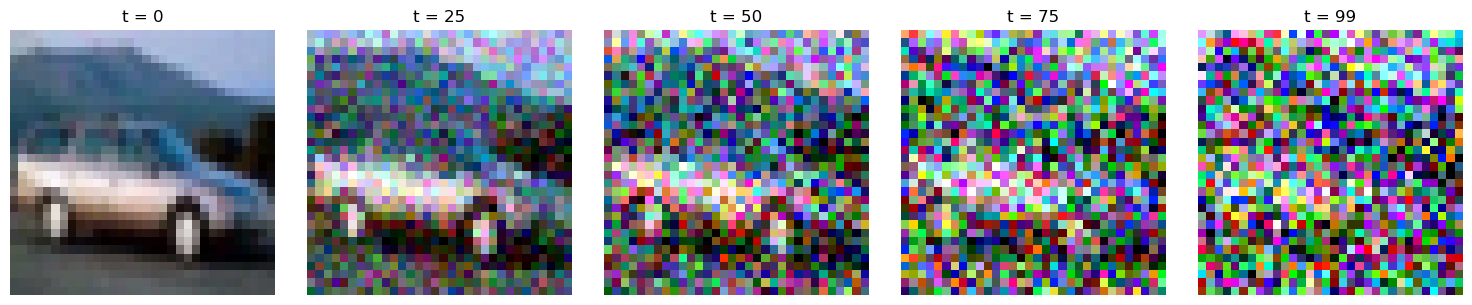

In [11]:
# time steps
T = 100
# create beta schedule
betas = linear_beta_schedule(timesteps=T)
# precompute terms
terms = precompute_terms(betas)
# define timesteps for visualization
timesteps_to_sample = [0, 25, 50, 75, 99]

# ectract single overfit image
x_0 = images_overfit[0].unsqueeze(0) # shape: (1, C, H, W)

# Generate noisy samples at the selected timesteps
noisy_images = []
for t_val in timesteps_to_sample:
    t_tensor = torch.tensor([t_val], dtype=torch.long)
    noisy_img, _ = forward_diffusion_sample(
        x_0, 
        t_tensor, 
        terms["sqrt_alphas_cumprod"], 
        terms["sqrt_one_minus_alphas_cumprod"], 
        device="cpu"
    )
    noisy_images.append(noisy_img[0]) # Remove batch dimension

# Helper function to denormalize and convert tensor for plotting
def denormalize_and_to_numpy(tensor_image):
    """
    Denormalizes and converts a tensor image to numpy for plotting.(helperfunction)
    """
    # The original transform was Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    # therefore apply the inverse transform: image * 0.5 + 0.5
    image = tensor_image.clone().detach()
    image = (image * 0.5) + 0.5
    # Clamp to [0,1] for plotting in rgb
    image = image.clamp(0,1)
    # Convert from Channels,Hight,Width (C,H,W) to H,W,C and to numpy
    image_np = image.permute(1,2,0).cpu()#.numpy()
    return image_np


# Plot the original and noisy samples
fig, axes = plt.subplots(1, len(timesteps_to_sample), figsize=(15, 3))
for ax, img, t in zip(axes, noisy_images, timesteps_to_sample):
    ax.imshow(denormalize_and_to_numpy(img))
    ax.set_title(f"t = {t}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Simple Diffusion

In [12]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
            
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        #self.bnorm1 = nn.BatchNorm2d(out_ch) #changed to groupnorm
        #self.bnorm2 = nn.BatchNorm2d(out_ch) #changed ro groupnorm
        self.gnorm1 = nn.GroupNorm(32, out_ch)
        self.gnorm2 = nn.GroupNorm(32, out_ch)

        self.relu  = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        #h = self.bnorm1(self.relu(self.conv1(x)))# erstezt gnorm
        h = self.gnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        # h = self.bnorm2(self.relu(self.conv2(h))) #ersetzt gnorm
        h = self.gnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings

In [13]:
class SimpleUnet(nn.Module):
    """
    A simple variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 64 #changed from 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        # Output
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1) #TODO: Check if new is correct
        #self.output = nn.Sequential(
        #    nn.Conv2d(up_channels[-1], out_dim, 1),
        #    nn.Tanh()
        #)


    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [14]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62534147


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=64, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (gnorm1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (gnorm2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=64, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    

## Loss function

In [15]:
def get_loss(model, x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device):
    x_noisy, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device)
    noise_pred = model(x_noisy, t)
    #print("Noise predicted min/max:", noise_pred.min().item(), noise_pred.max().item())
    return F.mse_loss(noise, noise_pred)

 tried l1_loss and now mse_loss

## sampling

In [16]:
@torch.no_grad() # to prevent memory out of bounds
def sample_timestep(x, t,sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, betas, model, posterior_variance):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t + 1e-5
    ) # 1e-5 is added to prevent division by zero
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t.item() == 0:
        # The t's are offset from the t's in the paper https://arxiv.org/pdf/2006.11239
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(T,sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, betas, model, posterior_variance):
    # Sample random noise
    img = torch.randn((1, 3, 32, 32), device=device)
    
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)
    
    for i in range(0,T)[::-1]: # Iterates over T to 0, because the diffusion process goes backwards
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, betas, model, posterior_variance)
        #img = torch.clamp(img, -1.0, 1.0) TODO: maybe use clamp
        
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            plt.imshow(denormalize_and_to_numpy(img[0]))
            plt.axis('off')
    
    plt.imshow(denormalize_and_to_numpy(img[0]))
    plt.axis('off')
            
    plt.show()
    
    return img

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #changed from 1e-4
epochs = 30_000
BATCH_SIZE = 1
T = 100

  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 0 Loss: 0.9823780059814453
Epoch 100 Loss: 0.25375956296920776


/tmp/ipykernel_1198/3253869418.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


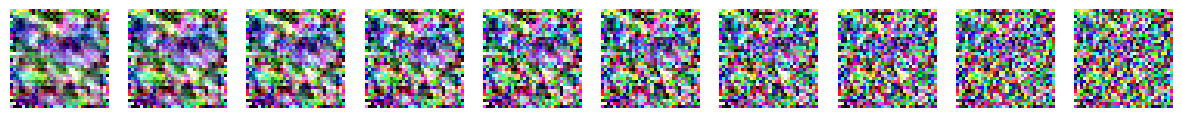

Epoch 200 Loss: 0.29668769240379333
Epoch 300 Loss: 0.10445649921894073
Epoch 400 Loss: 0.11161203682422638
Epoch 500 Loss: 0.10101133584976196
Epoch 600 Loss: 0.050073664635419846
Epoch 700 Loss: 0.04006606712937355
Epoch 800 Loss: 0.06096383184194565
Epoch 900 Loss: 0.07181678712368011
Epoch 1000 Loss: 0.07624997198581696


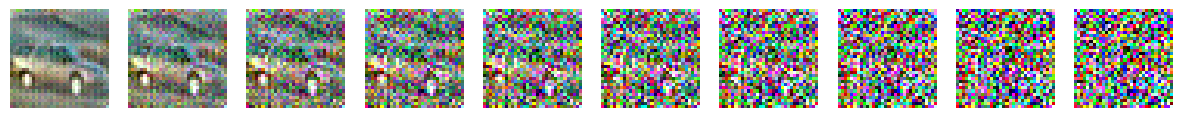

Epoch 1100 Loss: 0.030720308423042297
Epoch 1200 Loss: 0.0489281490445137
Epoch 1300 Loss: 0.057930320501327515
Epoch 1400 Loss: 0.030997805297374725
Epoch 1500 Loss: 0.02291988581418991
Epoch 1600 Loss: 0.026556100696325302
Epoch 1700 Loss: 0.02159440517425537
Epoch 1800 Loss: 0.037086840718984604
Epoch 1900 Loss: 0.021149834617972374
Epoch 2000 Loss: 0.1030726358294487
Epoch 2100 Loss: 0.09760495275259018
Epoch 2200 Loss: 0.02770467847585678
Epoch 2300 Loss: 0.03222513198852539
Epoch 2400 Loss: 0.029682770371437073
Epoch 2500 Loss: 0.0740528553724289
Epoch 2600 Loss: 0.01607430726289749
Epoch 2700 Loss: 0.016373008489608765
Epoch 2800 Loss: 0.5236680507659912
Epoch 2900 Loss: 0.020601797848939896
Epoch 3000 Loss: 0.01952552981674671
Epoch 3100 Loss: 0.019347645342350006
Epoch 3200 Loss: 0.02185201272368431
Epoch 3300 Loss: 0.03334828466176987
Epoch 3400 Loss: 0.02839554473757744
Epoch 3500 Loss: 0.018979594111442566
Epoch 3600 Loss: 0.035150036215782166
Epoch 3700 Loss: 0.01442318037

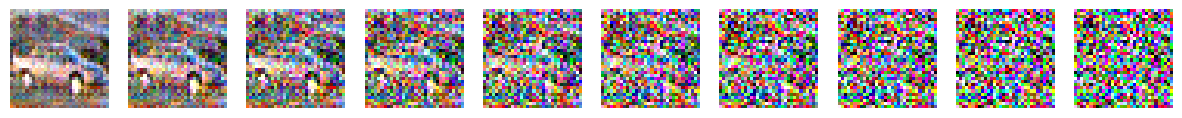

Epoch 5100 Loss: 0.011866187676787376
Epoch 5200 Loss: 0.02526552602648735
Epoch 5300 Loss: 0.16909997165203094
Epoch 5400 Loss: 0.017321735620498657
Epoch 5500 Loss: 0.012811491265892982
Epoch 5600 Loss: 0.01334715448319912
Epoch 5700 Loss: 0.039801597595214844
Epoch 5800 Loss: 0.037035129964351654
Epoch 5900 Loss: 0.013464797288179398
Epoch 6000 Loss: 0.01898530125617981
Epoch 6100 Loss: 0.02023368328809738
Epoch 6200 Loss: 0.013042256236076355
Epoch 6300 Loss: 0.014138633385300636
Epoch 6400 Loss: 0.028114672750234604
Epoch 6500 Loss: 0.015502668917179108
Epoch 6600 Loss: 0.04047413915395737
Epoch 6700 Loss: 0.009794078767299652
Epoch 6800 Loss: 0.012144945561885834
Epoch 6900 Loss: 0.015846500173211098
Epoch 7000 Loss: 0.013923443853855133
Epoch 7100 Loss: 0.012092823162674904
Epoch 7200 Loss: 0.010306060314178467
Epoch 7300 Loss: 0.009365295991301537
Epoch 7400 Loss: 0.007925707846879959
Epoch 7500 Loss: 0.0155427735298872
Epoch 7600 Loss: 0.012560907751321793
Epoch 7700 Loss: 0.0

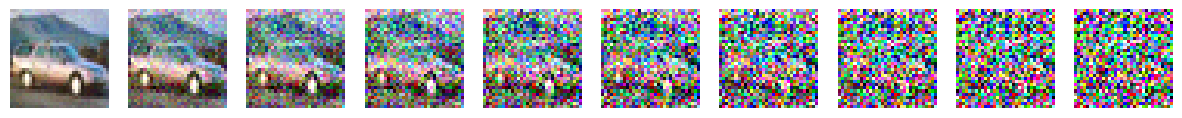

Epoch 10100 Loss: 0.08722960948944092
Epoch 10200 Loss: 0.01742871105670929
Epoch 10300 Loss: 0.020804135128855705
Epoch 10400 Loss: 0.021137714385986328
Epoch 10500 Loss: 0.008387481793761253
Epoch 10600 Loss: 0.022250302135944366
Epoch 10700 Loss: 0.008503876626491547
Epoch 10800 Loss: 0.014598148874938488
Epoch 10900 Loss: 0.013491896912455559
Epoch 11000 Loss: 0.010080818086862564
Epoch 11100 Loss: 0.007540314458310604
Epoch 11200 Loss: 0.00729799922555685
Epoch 11300 Loss: 0.016757868230342865
Epoch 11400 Loss: 0.01672453060746193
Epoch 11500 Loss: 0.04356836527585983
Epoch 11600 Loss: 0.02107619121670723
Epoch 11700 Loss: 0.008635866455733776
Epoch 11800 Loss: 0.008134327828884125
Epoch 11900 Loss: 0.008689148351550102
Epoch 12000 Loss: 0.007608848623931408
Epoch 12100 Loss: 0.010546225123107433
Epoch 12200 Loss: 0.0201062373816967
Epoch 12300 Loss: 0.010895448736846447
Epoch 12400 Loss: 0.027404209598898888
Epoch 12500 Loss: 0.009698495268821716
Epoch 12600 Loss: 0.0116863325238

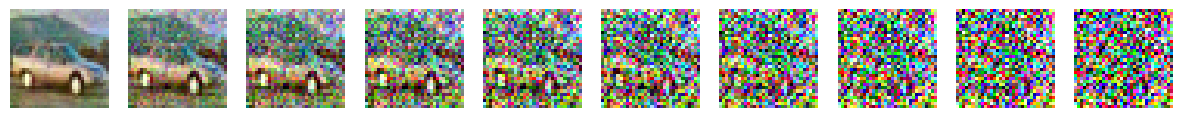

Epoch 15100 Loss: 0.04705367237329483
Epoch 15200 Loss: 0.011958512477576733
Epoch 15300 Loss: 0.006740488111972809
Epoch 15400 Loss: 0.00544350128620863
Epoch 15500 Loss: 0.011253472417593002
Epoch 15600 Loss: 0.011207213625311852
Epoch 15700 Loss: 0.00904916599392891
Epoch 15800 Loss: 0.03766539320349693
Epoch 15900 Loss: 0.01042682584375143
Epoch 16000 Loss: 0.0554247722029686
Epoch 16100 Loss: 0.007187345530837774
Epoch 16200 Loss: 0.010297111235558987
Epoch 16300 Loss: 0.006947518792003393
Epoch 16400 Loss: 0.02524343691766262
Epoch 16500 Loss: 0.0074340603314340115
Epoch 16600 Loss: 0.004663478583097458
Epoch 16700 Loss: 0.019345540553331375
Epoch 16800 Loss: 0.021514184772968292
Epoch 16900 Loss: 0.02108326181769371
Epoch 17000 Loss: 0.007038602605462074
Epoch 17100 Loss: 0.009862919338047504
Epoch 17200 Loss: 0.1521000862121582
Epoch 17300 Loss: 0.013234841637313366
Epoch 17400 Loss: 0.004760229028761387
Epoch 17500 Loss: 0.012263566255569458
Epoch 17600 Loss: 0.010788610205054

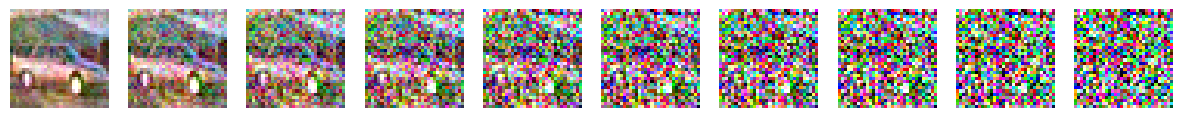

Epoch 20100 Loss: 0.005708061158657074
Epoch 20200 Loss: 0.005320193246006966
Epoch 20300 Loss: 0.004734166897833347
Epoch 20400 Loss: 0.008131813257932663
Epoch 20500 Loss: 0.00679702777415514
Epoch 20600 Loss: 0.005763144697993994
Epoch 20700 Loss: 0.0074814981780946255
Epoch 20800 Loss: 0.006084745284169912
Epoch 20900 Loss: 0.050574690103530884
Epoch 21000 Loss: 0.005551631562411785
Epoch 21100 Loss: 0.011967983096837997
Epoch 21200 Loss: 0.027116645127534866
Epoch 21300 Loss: 0.006947141140699387
Epoch 21400 Loss: 0.005500195547938347
Epoch 21500 Loss: 0.007748406380414963
Epoch 21600 Loss: 0.029183194041252136
Epoch 21700 Loss: 0.011715802364051342
Epoch 21800 Loss: 0.007860403507947922
Epoch 21900 Loss: 0.007866431027650833
Epoch 22000 Loss: 0.01750781200826168
Epoch 22100 Loss: 0.007020908407866955
Epoch 22200 Loss: 0.10051558911800385
Epoch 22300 Loss: 0.014420023187994957
Epoch 22400 Loss: 0.005262366496026516
Epoch 22500 Loss: 0.0393657311797142
Epoch 22600 Loss: 0.010471603

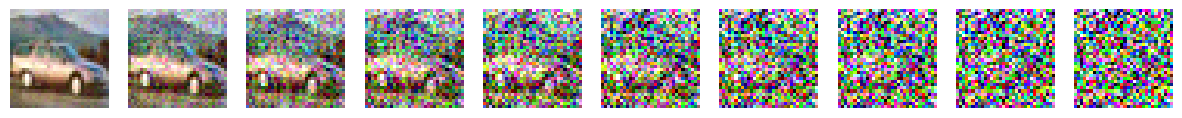

Epoch 25100 Loss: 0.005187984090298414
Epoch 25200 Loss: 0.004187495447695255
Epoch 25300 Loss: 0.05550248920917511
Epoch 25400 Loss: 0.026947936043143272
Epoch 25500 Loss: 0.006277482490986586
Epoch 25600 Loss: 0.01831042766571045
Epoch 25700 Loss: 0.009377820417284966
Epoch 25800 Loss: 0.09891673922538757
Epoch 25900 Loss: 0.0046046022325754166
Epoch 26000 Loss: 0.013770314864814281
Epoch 26100 Loss: 0.021351147443056107
Epoch 26200 Loss: 0.01188027486205101
Epoch 26300 Loss: 0.006685684900730848
Epoch 26400 Loss: 0.005626352038234472
Epoch 26500 Loss: 0.0055268509313464165
Epoch 26600 Loss: 0.013540178537368774
Epoch 26700 Loss: 0.007163110189139843
Epoch 26800 Loss: 0.005259547382593155
Epoch 26900 Loss: 0.0057975216768682
Epoch 27000 Loss: 0.21439962089061737
Epoch 27100 Loss: 0.0071420809254050255
Epoch 27200 Loss: 0.004439287818968296
Epoch 27300 Loss: 0.004158268216997385
Epoch 27400 Loss: 0.17122888565063477
Epoch 27500 Loss: 0.1003696471452713
Epoch 27600 Loss: 0.014435912482

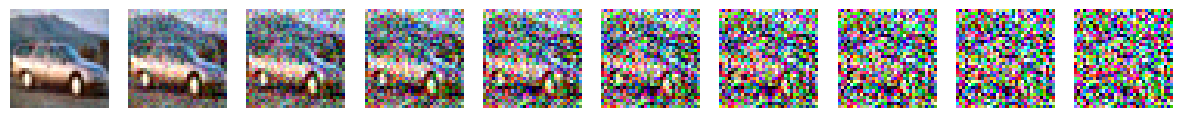

Epoch 29600 Loss: 0.008218210190534592
Epoch 29700 Loss: 0.005785536020994186
Epoch 29800 Loss: 0.005330182611942291
Epoch 29900 Loss: 0.005826171021908522


epoch,▁▁▂▃▅▆▇█
loss,▆▂▂▁▁▁▁█
epoch,29500
loss,0.36596


In [18]:
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, images_overfit, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        
        if epoch in {10, 100, 1000, 5000, 10000, 15000, 20000, 25000, 29500}:
            with torch.no_grad():
                x_gen = sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model, terms["posterior_variance"])
                
                wandb.log({
                "epoch": epoch,
                "loss": loss.item(),
            })
            
wandb.finish()

In [19]:
def compare_images(original, generated):
    """
    Zeigt Original und generiertes Bild nebeneinander in einem Plot an.
    original, generated: Tensors mit Shape (C, H, W)
    """
    orig_np = denormalize_and_to_numpy(original)
    gen_np = denormalize_and_to_numpy(generated)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(orig_np)
    axs[0].set_title("Original")
    axs[0].axis("off")
    
    axs[1].imshow(gen_np)
    axs[1].set_title("Generated")
    axs[1].axis("off")
    
    plt.show()

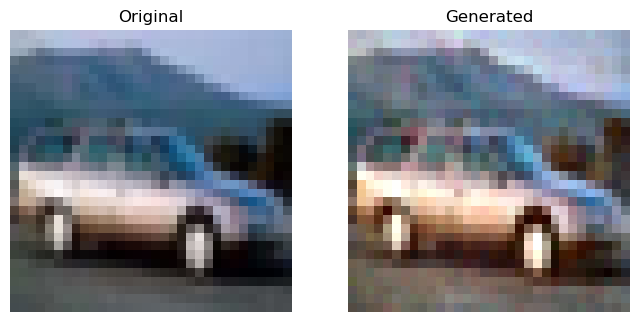

In [20]:
compare_images(images_overfit[0], x_gen[0])

In [21]:
x_gen_dn = denormalize_and_to_numpy(x_gen[0])
x_gen_dn.min()

tensor(0.)

#conclusion:
mit batchnorm wurde das bild mit der zeit mit einem bestimmten farbton versehen (ab epoche 1000) mit groupnorm konnte ich das leider auch nicht verhindern, jedoch die genauigkeit der pixel wurde insgesamt besser (bis epoche 10'000). Was auffällt ist, dass die groupnorm bei den ersten schritten ein viel knalligeres bild erzeugt, als mit der batchnorm. Nach einigen hundert, gleicht es sich dann aus. Die groupnorm performt aber dann wieder bei hohen epochen (30'000) besser, es kommt zu originalen farben besser hin.

#fragen:
diagnostische plots -> wandb
wie testen -> qualität eines generativen modells testen